(cape_part1)=
# Cape Part 1

This notebook shows how to calculate CAPE for soundings downloaded from the Wyoming website

In [1]:
import numpy as np
import pandas as pd
from pprint import pformat

from a405.thermo.constants import constants as c
from a405.thermo.thermlib import convertSkewToTemp, convertTempToSkew
from a405.skewT.fullskew import makeSkewWet,find_corners,make_default_labels

In [2]:
from a405.soundings.wyominglib import write_soundings, read_soundings
from matplotlib import pyplot as plt

## Grab a Little Rock sounding

In [3]:
write = False
if write:
    values=dict(region='naconf',year='2012',month='7',start='0100',stop='3000',station='72340')
    write_soundings(values, 'littlerock')
    soundings= read_soundings('littlerock')
else:
    soundings= read_soundings('littlerock')

In [4]:
soundings['sounding_dict'].keys()

dict_keys([(2012, 7, 1, 0), (2012, 7, 1, 12), (2012, 7, 2, 0), (2012, 7, 2, 12), (2012, 7, 3, 0), (2012, 7, 3, 12), (2012, 7, 4, 0), (2012, 7, 4, 12), (2012, 7, 5, 0), (2012, 7, 5, 12), (2012, 7, 6, 0), (2012, 7, 6, 12), (2012, 7, 7, 0), (2012, 7, 7, 12), (2012, 7, 8, 0), (2012, 7, 8, 12), (2012, 7, 9, 0), (2012, 7, 9, 12), (2012, 7, 10, 0), (2012, 7, 10, 12), (2012, 7, 11, 0), (2012, 7, 11, 12), (2012, 7, 12, 0), (2012, 7, 12, 12), (2012, 7, 13, 0), (2012, 7, 13, 12), (2012, 7, 14, 0), (2012, 7, 14, 12), (2012, 7, 15, 0), (2012, 7, 15, 12), (2012, 7, 16, 0), (2012, 7, 16, 12), (2012, 7, 17, 0), (2012, 7, 17, 12), (2012, 7, 18, 0), (2012, 7, 18, 12), (2012, 7, 19, 0), (2012, 7, 19, 12), (2012, 7, 20, 0), (2012, 7, 20, 12), (2012, 7, 21, 0), (2012, 7, 21, 12), (2012, 7, 22, 0), (2012, 7, 22, 12), (2012, 7, 23, 0), (2012, 7, 23, 12), (2012, 7, 24, 0), (2012, 7, 24, 12), (2012, 7, 25, 0), (2012, 7, 25, 12), (2012, 7, 26, 0), (2012, 7, 26, 12), (2012, 7, 27, 0), (2012, 7, 27, 12), (2012, 7

## Select one July 2012 sounding

In [5]:
day = 9
the_time=(2012,7,day,0)
sounding=soundings['sounding_dict'][the_time]
sounding.columns

Index(['Unnamed: 0', 'pres', 'hght', 'temp', 'dwpt', 'relh', 'mixr', 'drct',
       'sknt', 'thta', 'thte', 'thtv'],
      dtype='object')

## Save the metadata for plotting

In [6]:
title_string=soundings['attributes']['header']
index=title_string.find(' Observations at')
location=title_string[:index]
print(f'location: {location}')

units=soundings['attributes']['units'].split(';')
units_dict={}
for count,var in enumerate(sounding.columns[1:]):
    units_dict[var]=units[count]
#
# use the pretty printer to print the dictionary
#
print(f'units: {pformat(units_dict)}')

location: 72340 LZK Little Rock
units: {'drct': 'deg',
 'dwpt': 'C',
 'hght': 'm',
 'mixr': 'g/kg',
 'pres': 'hPa',
 'relh': '%',
 'sknt': 'knot',
 'temp': 'C',
 'thta': 'K',
 'thte': 'K',
 'thtv': 'K'}


## Convert temperature and dewpoint to skew coords

In [7]:
skew=35.
triplets=zip(sounding['temp'],sounding['dwpt'],sounding['pres'])
xcoord_T=[]
xcoord_Td=[]
for a_temp,a_dew,a_pres in triplets:
    xcoord_T.append(convertTempToSkew(a_temp,a_pres,skew))
    xcoord_Td.append(convertTempToSkew(a_dew,a_pres,skew))

## Plot the sounding

In [8]:
def label_fun():
    """
    override the default rs labels with a tighter mesh
    """
    from numpy import arange
    #
    # get the default labels
    #
    tempLabels,rsLabels, thetaLabels, thetaeLabels = make_default_labels()
    #
    # change the temperature and rs grids
    #
    tempLabels = range(-40, 50, 2)
    rsLabels = [0.1, 0.25, 0.5, 1, 2, 3] + list(np.arange(4, 28, 2)) 
    return tempLabels,rsLabels, thetaLabels, thetaeLabels

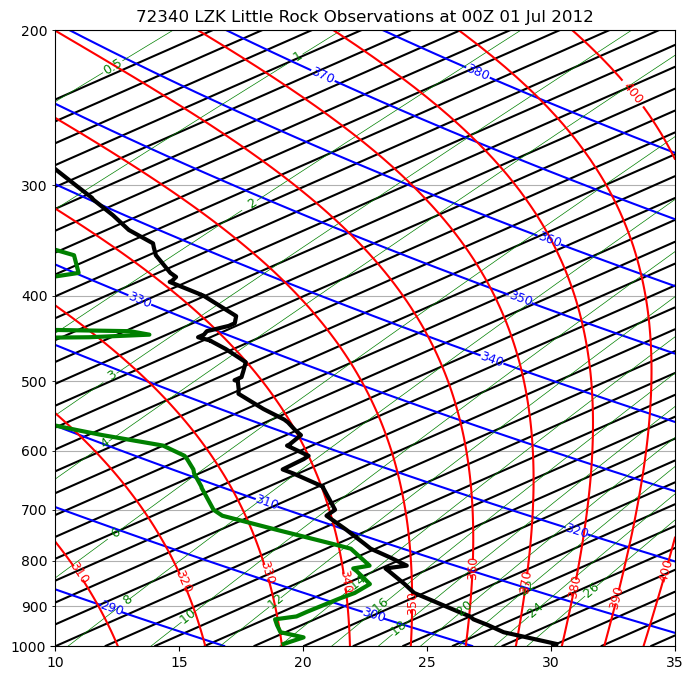

In [9]:
fig,ax =plt.subplots(1,1,figsize=(8,8))
corners = [10, 35]
ax, skew = makeSkewWet(ax, corners=corners, skew=skew,label_fun=label_fun)
#ax,skew = makeSkewWet(ax,corners=corners,skew=skew)
out=ax.set(title=title_string)
xcorners=find_corners(corners,skew=skew)
ax.set(xlim=xcorners,ylim=[1000,200]);
l1,=ax.plot(xcoord_T,sounding['pres'],color='k',label='temp')
l2,=ax.plot(xcoord_Td,sounding['pres'],color='g',label='dew')
[line.set(linewidth=3) for line in [l1,l2]];

### Turn off log(0) warning

In [10]:
np.seterr(all='ignore');

## CAPE calculation

The function below finds the buoyancy defined by Thompkins eq. 1.61 as a function of height, where Tv,a is the virtual temperature of the pseudoadiabat and Tv,env is the virtual temperature of your particular environmental sounding as a function of height using the lowest level to calculate the thetae for the moist adiabat. Check in a notebook that extends cape_part1_html by defining the function (ok to copy code from my library), running it and plotting it vs. height.

---

*Thompkins equation 1.61:*

$$
B = g\left(\frac{T_{v,a}-T_{v,env}}{T_{v,env}}\right)
$$

In [11]:
from numpy.typing import ArrayLike as array
import a405.thermo.thermlib as tl
from a405.thermo.constants import constants as c


def get_buoy(T: array, Td: array, pres: array) -> array:
    """
    Given an atmospheric sounding (Temperature and dew point profiles),
    calculate the buoyant force per unit mass (m/s2) of an air parcel
    originating from the surface as as it ascends. Thompkins Eqn 1.61

    Parameters
    ----------
    T, Td and press all need to be the same length

    T:  Temperature profile (K)
    Td:  Dew point temperature profile (K)
    pres: Pressures at which to calculate B (Pa)

    Returns
    -------

    B: Buoyancy per unit mass (m/s2)

    """
    # initialize arrays
    T_parcel = np.zeros_like(np.asarray(pres))
    
    ## 1) get the trajectory of the ascending parcel ##
    Tsurf = T[0]
    Tdsurf = Td[0]
    psurf = pres[0]
    theta_surf = tl.find_theta(Tsurf, c.p0)
    Tlcl, plcl = tl.find_lcl(Tdsurf, Tsurf, psurf)

    # trajectory below LCL follows dry adiabat
    T_parcel[pres > plcl] = tl.make_dry_adiabat(theta_surf, pres[pres > plcl])
    
    # trajectory above LCL follows moist adiabat
    thetaes = tl.find_thetaes(Tlcl, plcl)
    T_parcel[pres <= plcl] = [tl.find_Tmoist(thetaes, p, use_theta=True) for p in pres[pres <= plcl]]

    ## 2) calculate the buoyant force per unit mass
    # get the virtual temperatures of the sounding and pseudo-adiabatic ascent
    r_parcel = np.zeros_like(T_parcel)
    r_parcel[pres > plcl] = tl.find_rsat(Tdsurf, psurf) # unsaturated ascent
    r_parcel[pres <= plcl] = tl.find_rsat(T_parcel[pres <= plcl], pres[pres <= plcl]) # all water precipitates out
    Tv_parcel = tl.find_Tv(T_parcel, r_parcel)
   
    r_env = tl.find_rsat(Td, pres)
    Tv_env = tl.find_Tv(T, r_env)
    
    # Thompkins 1.61
    buoy = c.g0 * (Tv_parcel - Tv_env) / Tv_env
    return T_parcel, buoy

In [12]:
# convert pandas series to numpy  arrays with SI units and get buoyancy
temp = sounding['temp'].to_numpy() + c.Tc
dwpt = sounding['dwpt'].to_numpy() + c.Tc
pres = sounding['pres'].to_numpy() * c.hPa2pa
height = sounding['hght'].to_numpy()

T_parcel, buoy = get_buoy(temp, dwpt, pres)

## plot the result

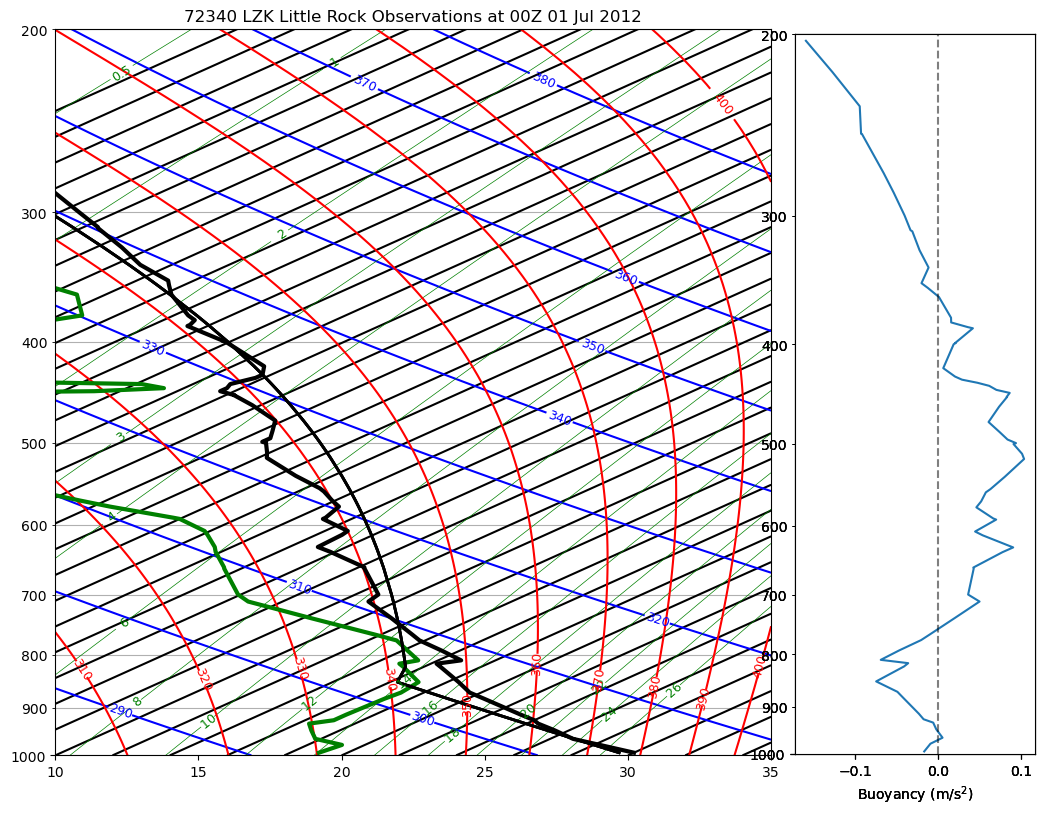

In [22]:
# add parcel trajectory (pseudo-adiabatic)
skew_parcel = convertTempToSkew(T_parcel - c.Tc, sounding.pres, skew)
ax.plot(skew_parcel, sounding.pres, "k", linewidth=2)

# add subplot to show buoyant force/mass with height
cutoff = sounding.pres > 200  # (hPa) 
ax2 = fig.add_axes((1, 0.05, 0.3, 0.9), sharey=ax)
ax2.plot(buoy[cutoff], sounding.pres[cutoff])
ax2.axvline(0, color="k", alpha=0.5, linestyle="--")
ax2.set_xlabel("Buoyancy (m/s$^2$)")

display(fig)

## Put this in a get_cape function

We've got the buoyancy now we need to find the vertical limits on the force x distance integral

In [14]:
# get the distance bw each point
cape_layers = np.diff(height)

In [15]:
# now we have a fencepost problem, one more buoy measurements than layers
# so average right and left levels of each layer
mid_buoy = (buoy[:-1] + buoy[1:])/2.
#
# get the positive values
#
hit_pos = mid_buoy > 0.

In [16]:
# solve by averaging the bouyancy across each layer
CAPE_elems = mid_buoy[hit_pos] * cape_layers[hit_pos] # F * dz
CAPE = np.sum(CAPE_elems)

In [17]:
print(f"{CAPE=:.1f} J/kg")

CAPE=295.1 J/kg


Put this in a function that takes in a sounding and calculates CAPE up to a specified cut pressure

In [18]:
def get_CAPE(sounding: dict):
    """
    calculates CAPE

    Parameters
    ----------

    sounding: dictionary of pandas series from wyoming sounding

    """
    temp = sounding["temp"].to_numpy() + c.Tc
    dwpt = sounding["dwpt"].to_numpy() + c.Tc
    pres = sounding["pres"].to_numpy() * c.hPa2pa
    levels = sounding['hght'].to_numpy()
  
    _, cape_buoy = get_buoy(temp, dwpt, pres)
    mid_buoy = (cape_buoy[:-1] + cape_buoy[1:])/2.
    cape_layers = np.diff(levels)
    hit_pos = mid_buoy > 0
    CAPE_elems = mid_buoy[hit_pos] * cape_layers[hit_pos]
    CAPE = np.sum(CAPE_elems)
    return CAPE

In [19]:
CAPE = get_CAPE(sounding)
print(f"{CAPE=:0.1f} J/kg")

CAPE=295.1 J/kg


## Compute the maximum vertical velocity

Now, we want the maximum updraft velocity.  Ignoring the effects of entrainment and aerodynamic drag, we can use the relation from our buoyancy notes or Thompkins 3.4:


$$
w_{max} = \sqrt{2 \,\text{CAPE}}\tag{AT3.4}
$$

Find $w_{max}$ of our sounding:

In [20]:
wmax = (2 * CAPE) ** 0.5
print(f"{wmax=:0.1f} m/s")

wmax=24.3 m/s


## To do

Write two rootfinders:

1) find the level of neutral buoyancy where the adiabat temperature crosses the environment
2) find the maximum cloud top  height where negative and positive CAPE balance